# Single Layer Perceptron

In [1]:
# Import libraries
from scipy import interp
from sklearn.metrics import roc_curve, auc
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
# Set variables
learning_rate = 0.01
train_step_num = 1000
batch_size = 100
class_num = 10

In [3]:
# Download mnist data
mnist = mnist_data.read_data_sets("../data/mnist", one_hot=True)

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
# Create symbolic variables
pixel_num = mnist.train.images.shape[1]
x = tf.placeholder("float", [None, pixel_num])
w = tf.Variable(tf.zeros([pixel_num, class_num]))
b = tf.Variable(tf.zeros([class_num]))
y_label = tf.placeholder("float", [None, class_num])

In [5]:
# Use softmax for prediction
y_pred = tf.nn.softmax(tf.matmul(x, w) + b)

In [6]:
# Use cross entroy error for loss
loss = -tf.reduce_sum(y_label * tf.log(y_pred))

In [7]:
# Set train
train = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [8]:
# Init and create session
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

In [9]:
# Train
for step in range(train_step_num):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    sess.run(train, feed_dict={x: batch_x, y_label: batch_y})

In [10]:
# Calculate accuracy
y_equal = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_label, 1))
accuracy = tf.reduce_mean(tf.cast(y_equal, "float"))
test_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y_label:mnist.test.labels})
print("Accuracy: {}".format(test_accuracy))

Accuracy: 0.8902999758720398


In [11]:
# Get pred score and label of test set to compute ROC curve
y_pred_score = sess.run(y_pred, feed_dict={x: mnist.test.images})
y_label_test = mnist.test.labels

In [12]:
# Compute ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(class_num):
    fpr[i], tpr[i], _ = roc_curve(y_label_test[:, i], y_pred_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Micro average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_label_test.ravel(), y_pred_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_num)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(class_num):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= class_num

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [13]:
# Create simple draw function
def draw_roc(fpr, tpf, curve_name, color, ax):
    ax.plot(fpr[curve_name], tpr[curve_name], color=color, linewidth=3)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.legend(["ROC curve, AUC = {:0.5f}".format(roc_auc[curve_name])], loc="lower right")
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title("{}-average ROC curve".format(curve_name.title()))

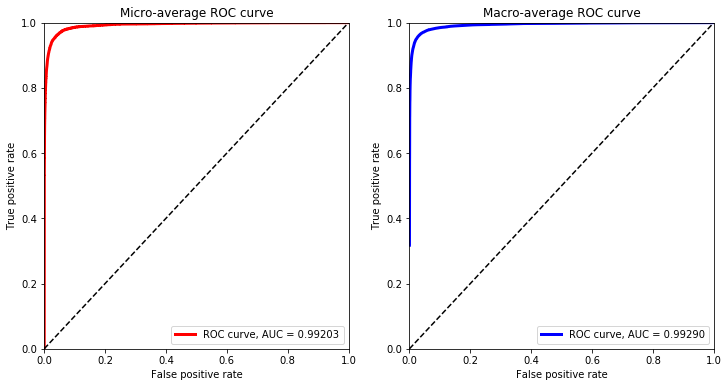

In [14]:
# Draw ROC graph
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
draw_roc(fpr, tpr, "micro", "r", ax[0])
draw_roc(fpr, tpr, "macro", "b", ax[1])